```**python**
Add IC50 or potency columns to test files
```

In [9]:
import os
import pandas as pd

# File paths for input files
#file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/1_filter/test_reg.csv"  # Path to the first CSV file
#file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/1_filter/test_class.csv"  # Path to the first CSV file
file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/1_filter/test_class.csv"  # Path to the first CSV file
file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

#file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/test_reg.csv"  # Path to the first CSV file
#file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

#file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/test_class.csv"  # Path to the first CSV file
#file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

# Debug: Check if files exist
print("File1 exists:", os.path.exists(file1))
print("File2 exists:", os.path.exists(file2))

# Output file
#output_file = "PCA_pre_filtered/input/test_reduced_reg_wIC50.csv"
#output_file = "PCA_pre_filtered/input/test_reduced_class_Potency.csv"
#output_file = "PCA_post_filtered/input/test_reduced_reg_wIC50.csv"
output_file = "PCA_post_filtered/input/test_reduced_class_Potency.csv"

# Read the CSV files into pandas DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure only Molecule ChEMBL ID and IC50 columns are used from file2
#df2 = df2[["Molecule ChEMBL ID", "-logIC50"]]  # Adjust "IC50" to the actual column name in file2
df2 = df2[["Molecule ChEMBL ID", "Potency"]]  # Adjust "IC50" to the actual column name in file2

# Merge the two files based on the "Molecule ChEMBL ID" column, keeping all rows in df1
merged_df = pd.merge(df1, df2, on="Molecule ChEMBL ID", how="left")  # Use "left" join to keep all rows from file1

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

print(f"Merged file saved to {output_file}")





File1 exists: True
File2 exists: True
Merged file saved to PCA_post_filtered/input/test_reduced_class_Potency.csv


This script performs machine learning workflows for regression and classification tasks using XGBoost models. The pipeline includes:

Cross-Validation with Hyperparameter Tuning:
Implements 5-fold cross-validation.
Optimizes model hyperparameters using RandomizedSearchCV.
Generates data distribution plots (train vs. validation) for each fold.

Model Training and Evaluation:
Trains the best-tuned model on the entire training dataset.
Evaluates the model on the test dataset.
Outputs performance metrics (e.g., MSE, R², accuracy, recall, F1-score) and saves them in a performance summary.

Visualization:
Plots feature importance for tree-based models.
Creates actual vs. predicted plots for regression.
Generates ROC curves and confusion matrices for classification.



# Regression Analyis


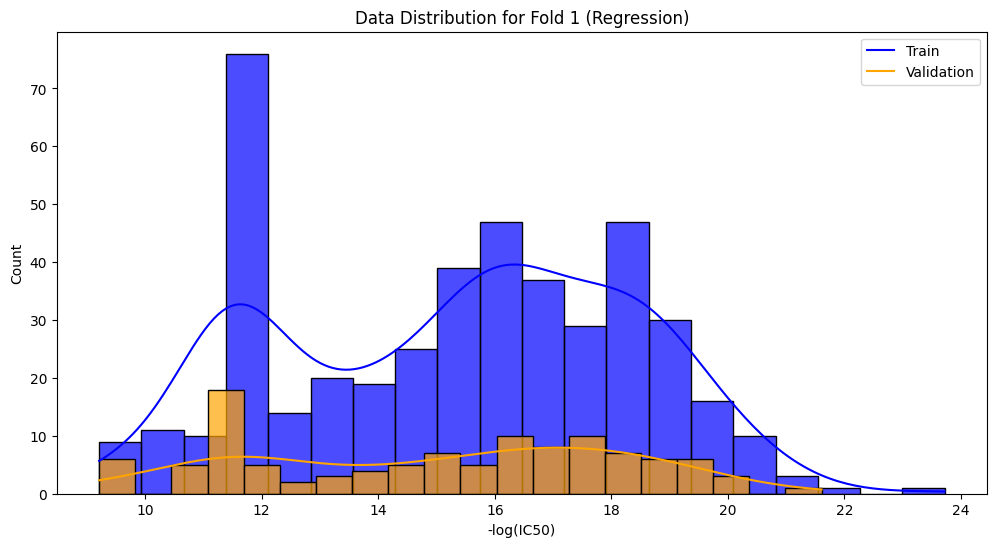

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 - Best Model Metric: 4.1120


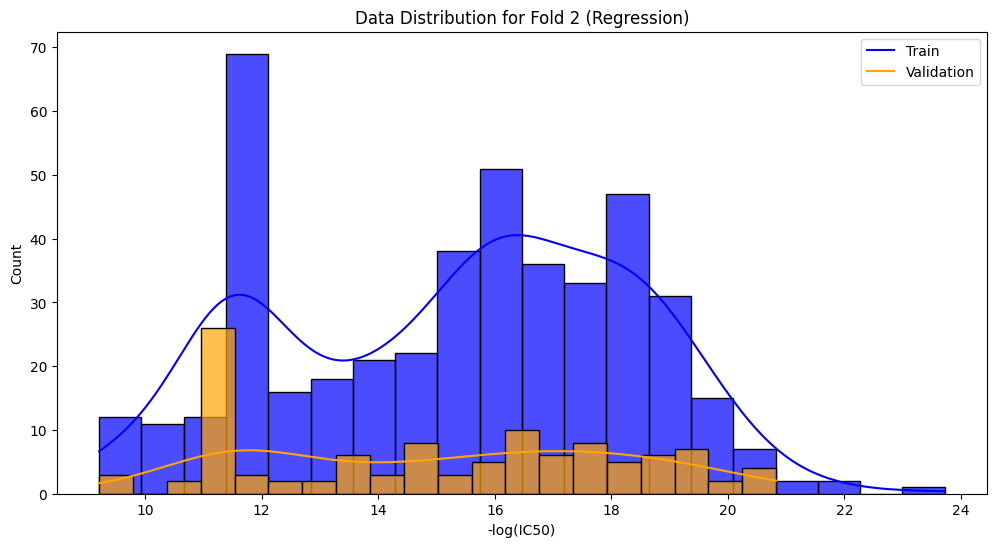

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 2 - Best Model Metric: 3.5480


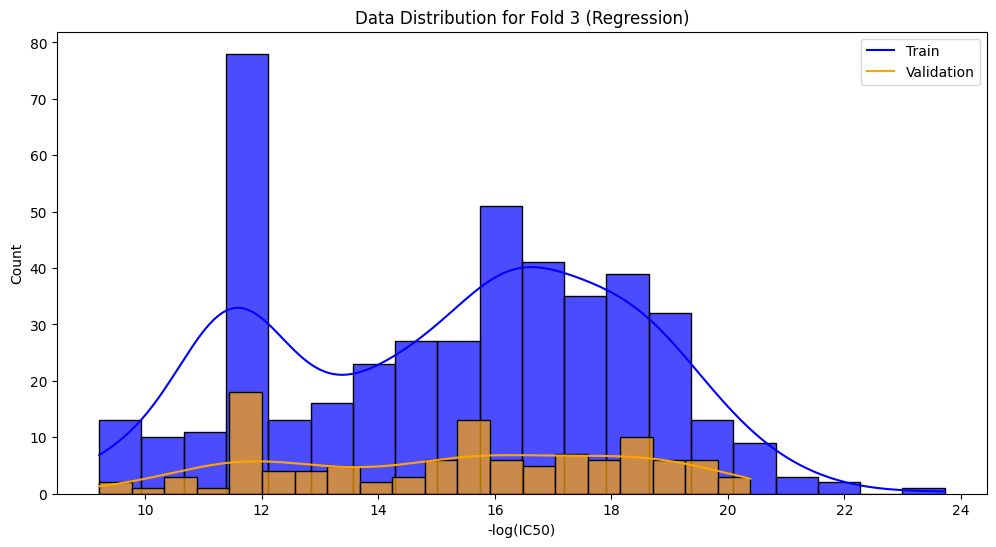

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 3 - Best Model Metric: 3.6532


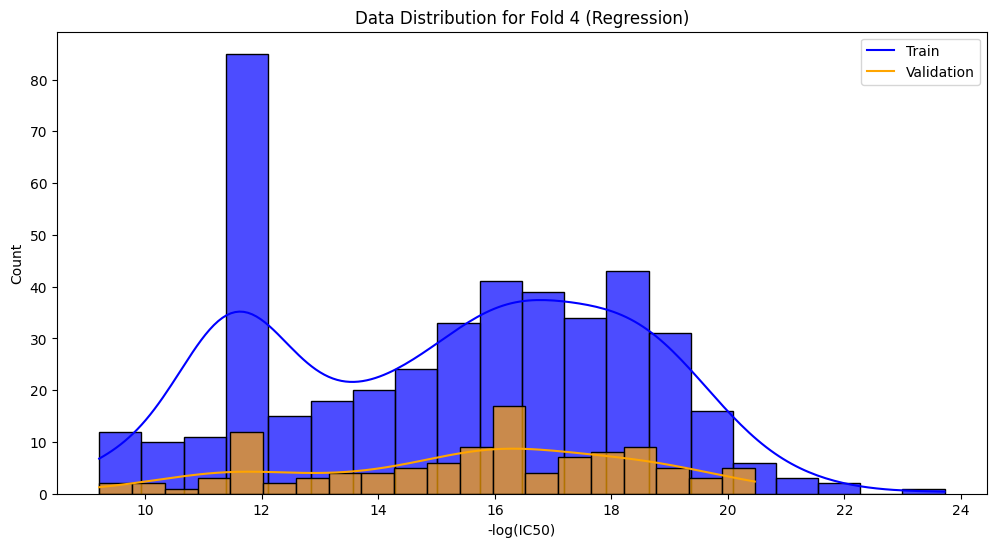

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 4 - Best Model Metric: 3.3004


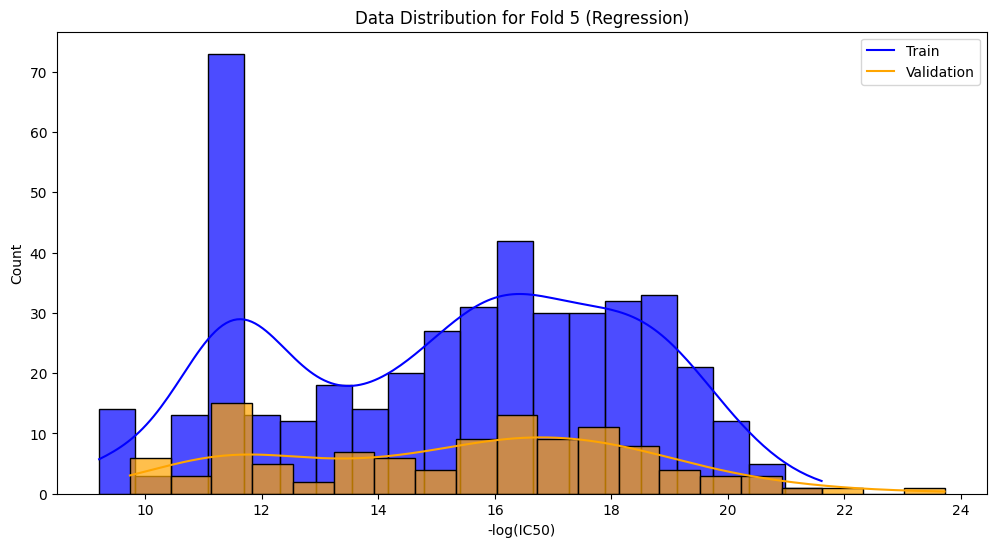

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 5 - Best Model Metric: 4.6500


<Figure size 1000x800 with 0 Axes>

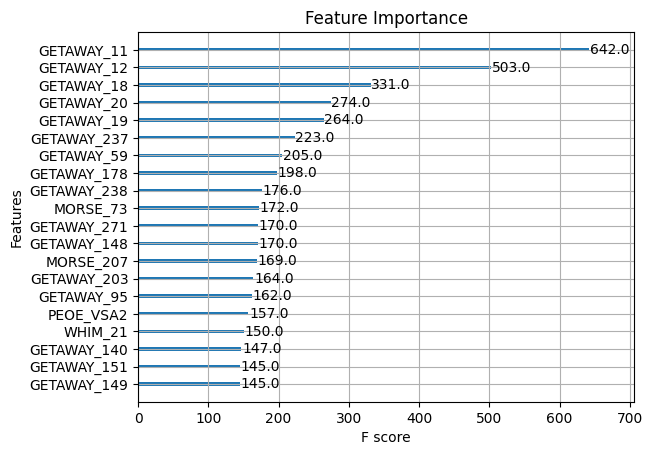

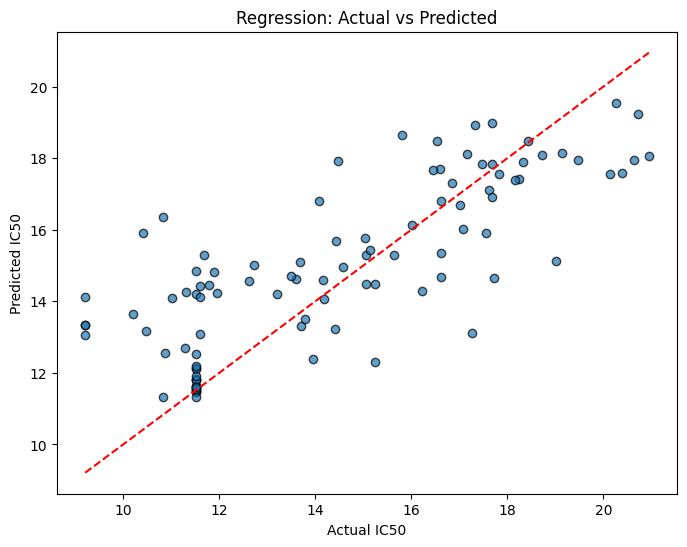

Test Metrics: {'MSE': 4.1556137076757516, 'R²': 0.5834216986686107}


In [43]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, r2_score, roc_curve, auc
)
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import gaussian_kde


def get_file_paths(problem_type, input_type_pca, input_type_filter):
    """
    Generate file paths dynamically based on problem type and input type.
    """
    problem = "reg" if problem_type == "regression" else "class"
    base_dir_pca = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_pca}/post_1_filter/{problem}/"
    base_dir_filter = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_filter}/"
    train_file = os.path.join(base_dir_pca, f"train_pca_reduced_{problem}.csv")
    #test_file = 'PCA_post_filtered/input/test_reduced_class_Potency.csv'
    test_file = 'PCA_post_filtered/input/test_reduced_reg_wIC50.csv'
    return train_file, test_file


def load_data(problem_type, train_file, test_file, save_dir=None):
    """
    Load training and test datasets.
    """
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    label_encoder = None

    train_chembl_ids = train_data['Molecule ChEMBL ID']
    test_chembl_ids = test_data['Molecule ChEMBL ID']

    if problem_type == 'regression':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_train = train_data['-logIC50']
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_test = test_data['-logIC50']
    elif problem_type == 'classification':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_train = train_data['Potency'].str.strip()
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_test = test_data['Potency'].str.strip()

        label_encoder = LabelEncoder()
        y_train = pd.Series(label_encoder.fit_transform(y_train), index=y_train.index)
        y_test = pd.Series(label_encoder.transform(y_test), index=y_test.index)

        # Print label mapping for classification
        print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

    # Ensure test data matches training feature columns
    train_features = X_train.columns
    for col in set(train_features) - set(X_test.columns):
        X_test[col] = 0
    X_test = X_test[train_features]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        train_data.to_csv(os.path.join(save_dir, 'modified_train.csv'), index=False)
        test_data.to_csv(os.path.join(save_dir, 'modified_test.csv'), index=False)

    return X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids



def cross_validation(problem_type, model, X_train, y_train, n_splits=5, output_dir=None, label_encoder=None):
    """
    Perform cross-validation with data distribution plots and hyperparameter tuning.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    tuned_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Plot data distribution for the current fold
        plt.figure(figsize=(12, 6))
        if problem_type == "regression":
            sns.histplot(y_train_fold, kde=True, label="Train", color="blue", bins=20, alpha=0.7)
            sns.histplot(y_val_fold, kde=True, label="Validation", color="orange", bins=20, alpha=0.7)
            plt.xlabel("-log(IC50)")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Regression)")
        else:
            sns.countplot(
                x=label_encoder.inverse_transform(y_train_fold),
                label="Train",
                color="blue",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            sns.countplot(
                x=label_encoder.inverse_transform(y_val_fold),
                label="Validation",
                color="orange",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            plt.xlabel("Class")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Classification)")

        plt.legend(["Train", "Validation"])
        if output_dir:
            plt.savefig(os.path.join(output_dir, f"fold_{fold}_data_distribution.png"), dpi=150)
        plt.show()

        # Hyperparameter tuning with RandomizedSearchCV
        param_distributions = {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='neg_mean_squared_error' if problem_type == "regression" else 'accuracy',
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=42,
        )
        random_search.fit(X_train_fold, y_train_fold)

        best_model = random_search.best_estimator_
        tuned_models.append(best_model)

        y_val_pred = best_model.predict(X_val_fold)
        if problem_type == "regression":
            metric = mean_squared_error(y_val_fold, y_val_pred)
        elif problem_type == "classification" and label_encoder is not None:
            metric = accuracy_score(y_val_fold, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    return tuned_models, np.mean(fold_metrics)




def evaluate_model(problem_type, model, X_test, y_test, output_dir, label_encoder=None, test_chembl_ids=None):
    """
    Evaluate the model and save predictions and plots.
    """
    y_pred = model.predict(X_test)
    if problem_type == 'regression':
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(os.path.join(output_dir, "regression_predictions.csv"), index=False)

        # Actual vs Predicted plot
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.xlabel("Actual IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Regression: Actual vs Predicted")
        plt.savefig(os.path.join(output_dir, "regression_actual_vs_predicted.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "regression",
            "input_type": "PCA",
            "MSE": mse,
            "R²": r2
        }])
        performance_summary.to_csv(os.path.join(output_dir, "regression_performance_summary.csv"), index=False)

        return {"MSE": mse, "R²": r2}

    elif problem_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)

        # Convert numeric predictions and true labels back to original class names
        true_classes = label_encoder.inverse_transform(y_test)
        predicted_classes = label_encoder.inverse_transform(y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True Class": true_classes,
            "Predicted Class": predicted_classes
        })
        predictions.to_csv(os.path.join(output_dir, "classification_predictions.csv"), index=False)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix (Test Set)")
        plt.savefig(os.path.join(output_dir, "classification_confusion_matrix.png"))
        plt.show()

        # ROC curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(output_dir, "roc_curve.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "classification",
            "input_type": "PCA",
            "Accuracy": accuracy
        }])
        performance_summary.to_csv(os.path.join(output_dir, "classification_performance_summary.csv"), index=False)

        return {"Accuracy": accuracy}


def main(problem_type, input_type_pca, input_type_filter, output_dir, save_dir=None, model_type="xgboost"):
    """
    Main pipeline for modeling with cross-validation and plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    train_file, test_file = get_file_paths(problem_type, input_type_pca, input_type_filter)
    X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids = load_data(
        problem_type, train_file, test_file, save_dir
    )

    if model_type == "xgboost":
        model = XGBRegressor(random_state=42) if problem_type == 'regression' else XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    elif model_type == "random_forest":
        model = RandomForestRegressor(random_state=42) if problem_type == 'regression' else RandomForestClassifier(random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost' or 'random_forest'.")

    tuned_models, avg_metric = cross_validation(
        problem_type=problem_type,
        model=model,
        X_train=X_train,
        y_train=y_train,
        n_splits=5,
        output_dir=output_dir,
        label_encoder=label_encoder if problem_type == "classification" else None
    )
    best_model = tuned_models[np.argmin(avg_metric)] if problem_type == 'regression' else tuned_models[np.argmax(avg_metric)]

    # Feature importance plot
    if hasattr(best_model, "feature_importances_"):
        plt.figure(figsize=(10, 8))
        plot_importance(best_model, max_num_features=20)
        plt.title("Feature Importance")
        plt.savefig(os.path.join(output_dir, "feature_importance.png"))
        plt.show()

    # Evaluate on test set
    test_metrics = evaluate_model(problem_type, best_model, X_test, y_test, output_dir, label_encoder, test_chembl_ids)
    print(f"Test Metrics: {test_metrics}")


# Example Usage
main(
    problem_type='regression',  # 'classification' or 'regression'
    input_type_pca='PCA',
    input_type_filter='1_filter',
    output_dir=f'PCA_post_filtered/results/regression/',
    save_dir='PCA_post_filtered/modified_datasets/',
    model_type="xgboost"  # "xgboost" or "random_forest"
)


# Classification Analysis

Label Mapping: {'High Potency': 0, 'Low Potency': 1, 'Medium Potency': 2}


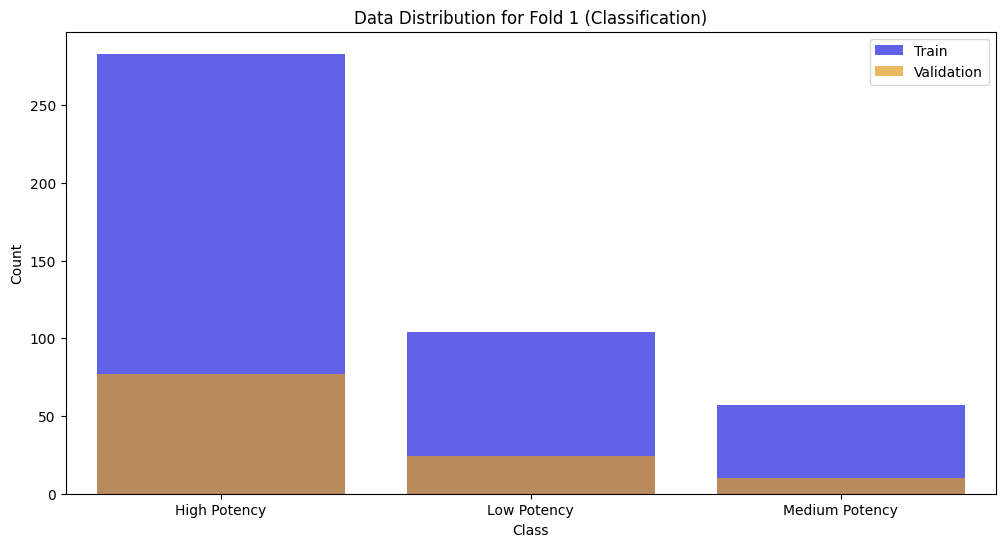

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 1 - Best Model Metric: 0.7838


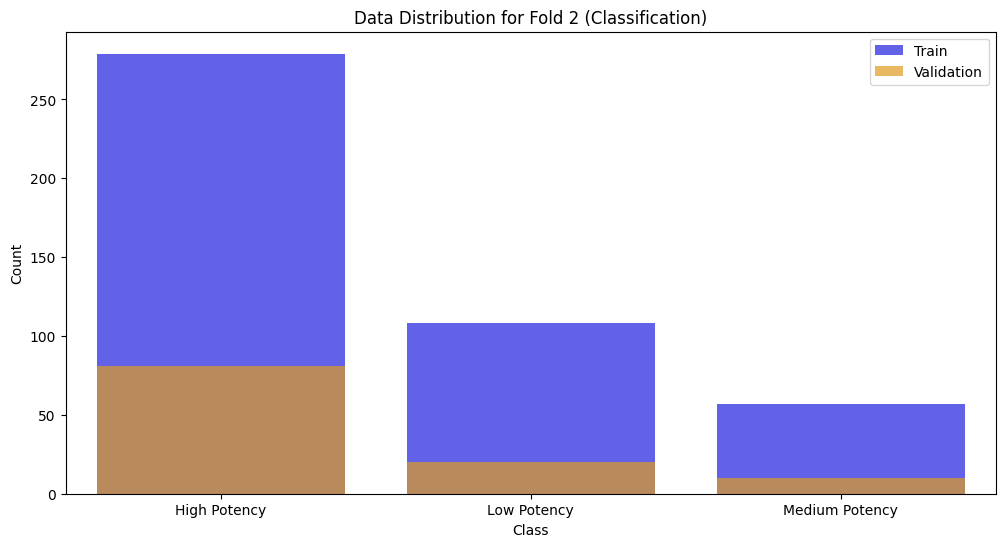

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 2 - Best Model Metric: 0.8288


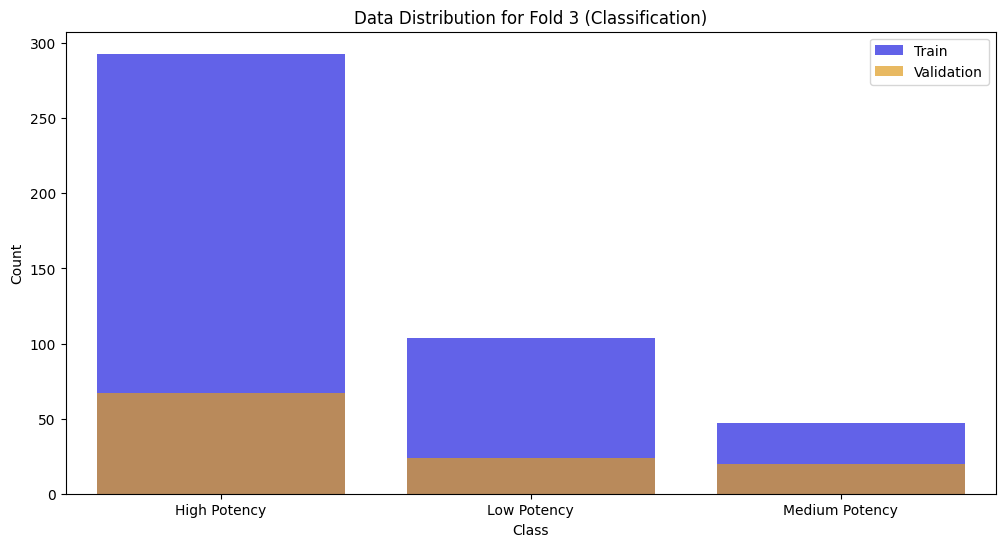

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 3 - Best Model Metric: 0.7477


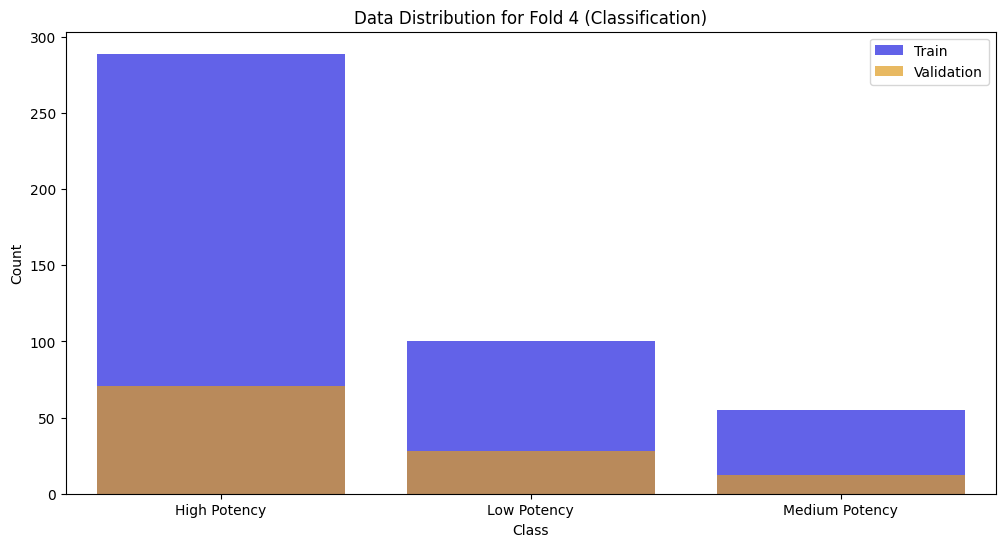

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 4 - Best Model Metric: 0.7928


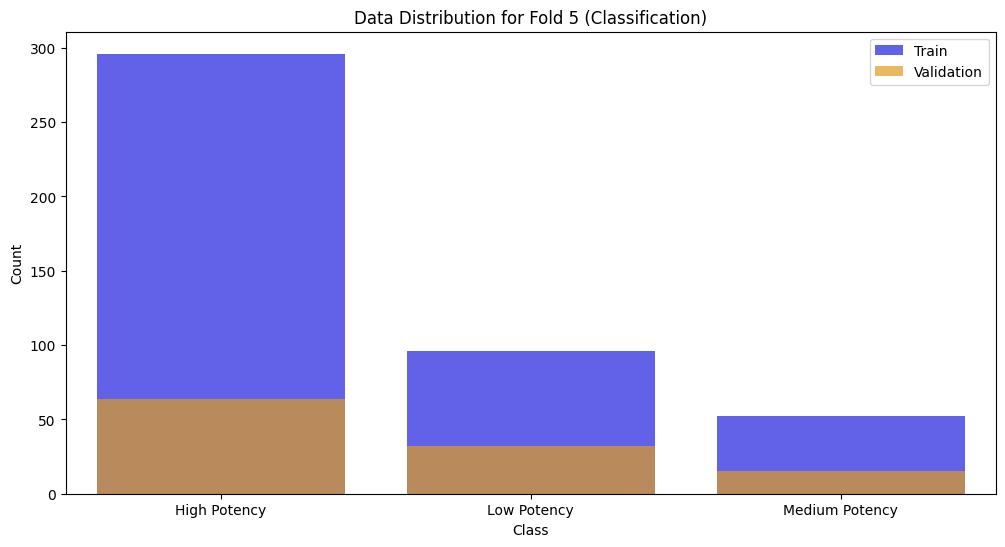

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 5 - Best Model Metric: 0.7297


<Figure size 1000x800 with 0 Axes>

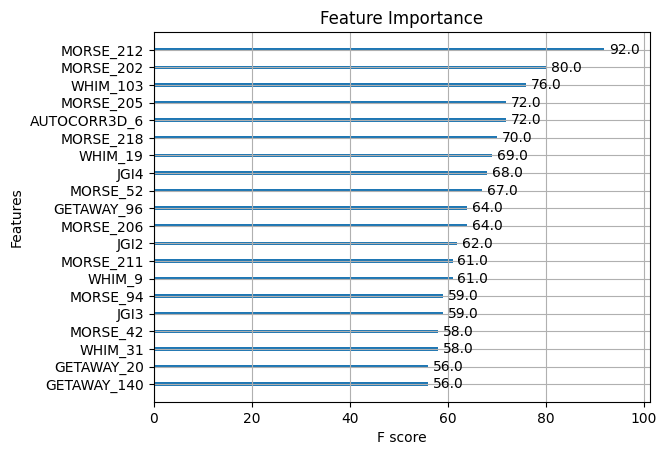

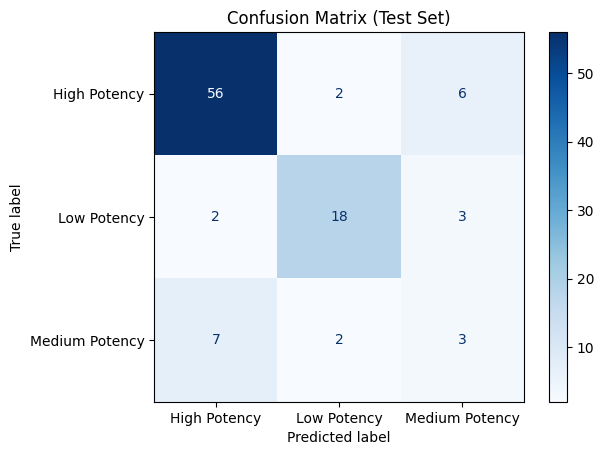

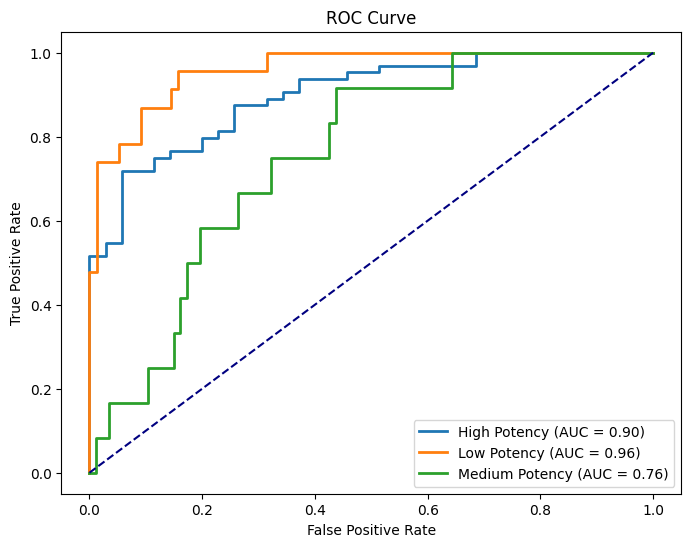

Test Metrics: {'Accuracy': 0.7777777777777778}


In [44]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, r2_score, roc_curve, auc
)
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import gaussian_kde


def get_file_paths(problem_type, input_type_pca, input_type_filter):
    """
    Generate file paths dynamically based on problem type and input type.
    """
    problem = "reg" if problem_type == "regression" else "class"
    base_dir_pca = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_pca}/post_1_filter/{problem}/"
    base_dir_filter = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_filter}/"
    train_file = os.path.join(base_dir_pca, f"train_pca_reduced_{problem}.csv")
    test_file = 'PCA_post_filtered/input/test_reduced_class_Potency.csv'
    #test_file = 'PCA_post_filtered/input/test_reduced_reg_wIC50.csv'
    return train_file, test_file


def load_data(problem_type, train_file, test_file, save_dir=None):
    """
    Load training and test datasets.
    """
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    label_encoder = None

    train_chembl_ids = train_data['Molecule ChEMBL ID']
    test_chembl_ids = test_data['Molecule ChEMBL ID']

    if problem_type == 'regression':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_train = train_data['-logIC50']
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_test = test_data['-logIC50']
    elif problem_type == 'classification':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_train = train_data['Potency'].str.split('\n').str[0].str.strip()
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_test = test_data['Potency'].str.split('\n').str[0].str.strip()

        label_encoder = LabelEncoder()
        y_train = pd.Series(label_encoder.fit_transform(y_train), index=y_train.index)
        y_test = pd.Series(label_encoder.transform(y_test), index=y_test.index)

        # Print label mapping for classification
        print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

    # Ensure test data matches training feature columns
    train_features = X_train.columns
    for col in set(train_features) - set(X_test.columns):
        X_test[col] = 0
    X_test = X_test[train_features]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        train_data.to_csv(os.path.join(save_dir, 'modified_train.csv'), index=False)
        test_data.to_csv(os.path.join(save_dir, 'modified_test.csv'), index=False)

    return X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids



def cross_validation(problem_type, model, X_train, y_train, n_splits=5, output_dir=None, label_encoder=None):
    """
    Perform cross-validation with data distribution plots and hyperparameter tuning.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    tuned_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Plot data distribution for the current fold
        plt.figure(figsize=(12, 6))
        if problem_type == "regression":
            sns.histplot(y_train_fold, kde=True, label="Train", color="blue", bins=20, alpha=0.7)
            sns.histplot(y_val_fold, kde=True, label="Validation", color="orange", bins=20, alpha=0.7)
            plt.xlabel("-log(IC50)")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Regression)")
        else:
            sns.countplot(
                x=label_encoder.inverse_transform(y_train_fold),
                label="Train",
                color="blue",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            sns.countplot(
                x=label_encoder.inverse_transform(y_val_fold),
                label="Validation",
                color="orange",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            plt.xlabel("Class")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Classification)")

        plt.legend(["Train", "Validation"])
        if output_dir:
            plt.savefig(os.path.join(output_dir, f"fold_{fold}_data_distribution.png"), dpi=150)
        plt.show()

        # Hyperparameter tuning with RandomizedSearchCV
        param_distributions = {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='neg_mean_squared_error' if problem_type == "regression" else 'accuracy',
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=42,
        )
        random_search.fit(X_train_fold, y_train_fold)

        best_model = random_search.best_estimator_
        tuned_models.append(best_model)

        y_val_pred = best_model.predict(X_val_fold)
        if problem_type == "regression":
            metric = mean_squared_error(y_val_fold, y_val_pred)
        elif problem_type == "classification" and label_encoder is not None:
            metric = accuracy_score(y_val_fold, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    return tuned_models, np.mean(fold_metrics)




def evaluate_model(problem_type, model, X_test, y_test, output_dir, label_encoder=None, test_chembl_ids=None):
    """
    Evaluate the model and save predictions and plots.
    """
    y_pred = model.predict(X_test)
    if problem_type == 'regression':
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(os.path.join(output_dir, "regression_predictions.csv"), index=False)

        # Actual vs Predicted plot
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.xlabel("Actual IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Regression: Actual vs Predicted")
        plt.savefig(os.path.join(output_dir, "regression_actual_vs_predicted.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "regression",
            "input_type": "PCA",
            "MSE": mse,
            "R²": r2
        }])
        performance_summary.to_csv(os.path.join(output_dir, "regression_performance_summary.csv"), index=False)

        return {"MSE": mse, "R²": r2}

    elif problem_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)

        # Convert numeric predictions and true labels back to original class names
        true_classes = label_encoder.inverse_transform(y_test)
        predicted_classes = label_encoder.inverse_transform(y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True Class": true_classes,
            "Predicted Class": predicted_classes
        })
        predictions.to_csv(os.path.join(output_dir, "classification_predictions.csv"), index=False)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix (Test Set)")
        plt.savefig(os.path.join(output_dir, "classification_confusion_matrix.png"))
        plt.show()

        # ROC curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(output_dir, "roc_curve.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "classification",
            "input_type": "PCA",
            "Accuracy": accuracy
        }])
        performance_summary.to_csv(os.path.join(output_dir, "classification_performance_summary.csv"), index=False)

        return {"Accuracy": accuracy}


def main(problem_type, input_type_pca, input_type_filter, output_dir, save_dir=None, model_type="xgboost"):
    """
    Main pipeline for modeling with cross-validation and plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    train_file, test_file = get_file_paths(problem_type, input_type_pca, input_type_filter)
    X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids = load_data(
        problem_type, train_file, test_file, save_dir
    )

    if model_type == "xgboost":
        model = XGBRegressor(random_state=42) if problem_type == 'regression' else XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    elif model_type == "random_forest":
        model = RandomForestRegressor(random_state=42) if problem_type == 'regression' else RandomForestClassifier(random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost' or 'random_forest'.")

    tuned_models, avg_metric = cross_validation(
        problem_type=problem_type,
        model=model,
        X_train=X_train,
        y_train=y_train,
        n_splits=5,
        output_dir=output_dir,
        label_encoder=label_encoder if problem_type == "classification" else None
    )
    best_model = tuned_models[np.argmin(avg_metric)] if problem_type == 'regression' else tuned_models[np.argmax(avg_metric)]

    # Feature importance plot
    if hasattr(best_model, "feature_importances_"):
        plt.figure(figsize=(10, 8))
        plot_importance(best_model, max_num_features=20)
        plt.title("Feature Importance")
        plt.savefig(os.path.join(output_dir, "feature_importance.png"))
        plt.show()

    # Evaluate on test set
    test_metrics = evaluate_model(problem_type, best_model, X_test, y_test, output_dir, label_encoder, test_chembl_ids)
    print(f"Test Metrics: {test_metrics}")


# Example Usage
main(
    problem_type='classification',  # 'classification' or 'regression'
    input_type_pca='PCA',
    input_type_filter='1_filter',
    output_dir=f'PCA_post_filtered/results/classification/',
    save_dir='PCA_post_filtered/modified_datasets/',
    model_type="xgboost"  # "xgboost" or "random_forest"
)


#     Compare these results to reduced feature data sets obtained straight from PCA analysis without initial filtering

## Regression analyis

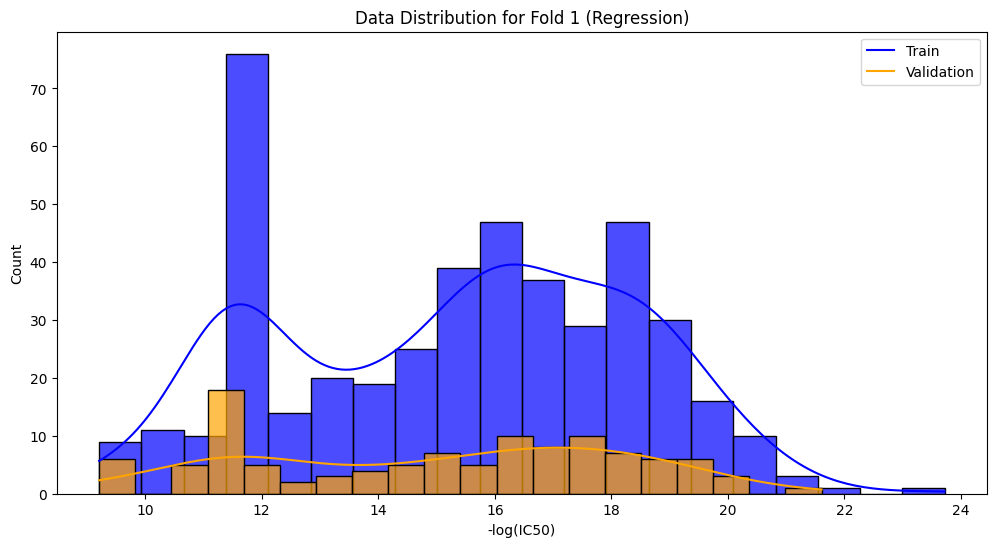

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 - Best Model Metric: 4.3674


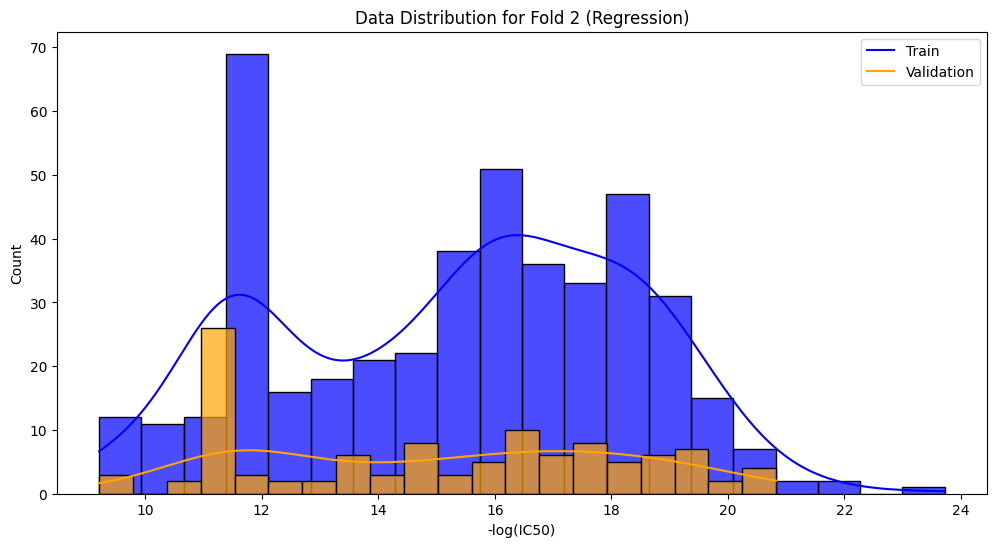

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 2 - Best Model Metric: 3.6138


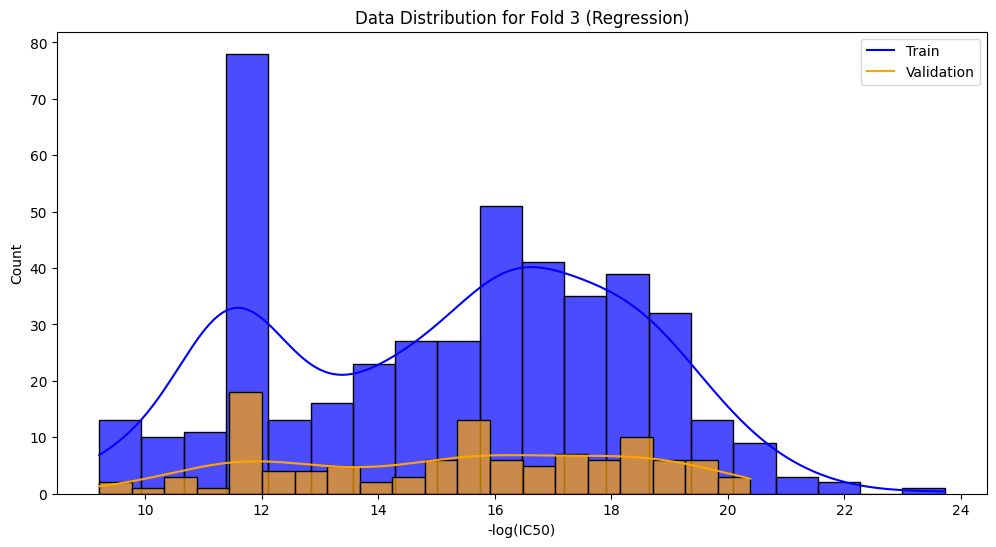

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 3 - Best Model Metric: 3.5684


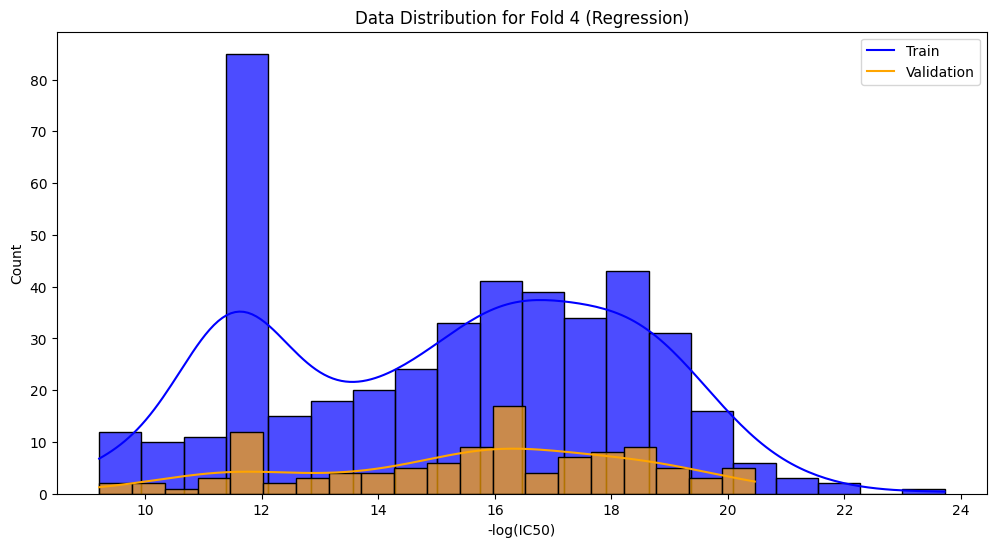

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 4 - Best Model Metric: 3.5320


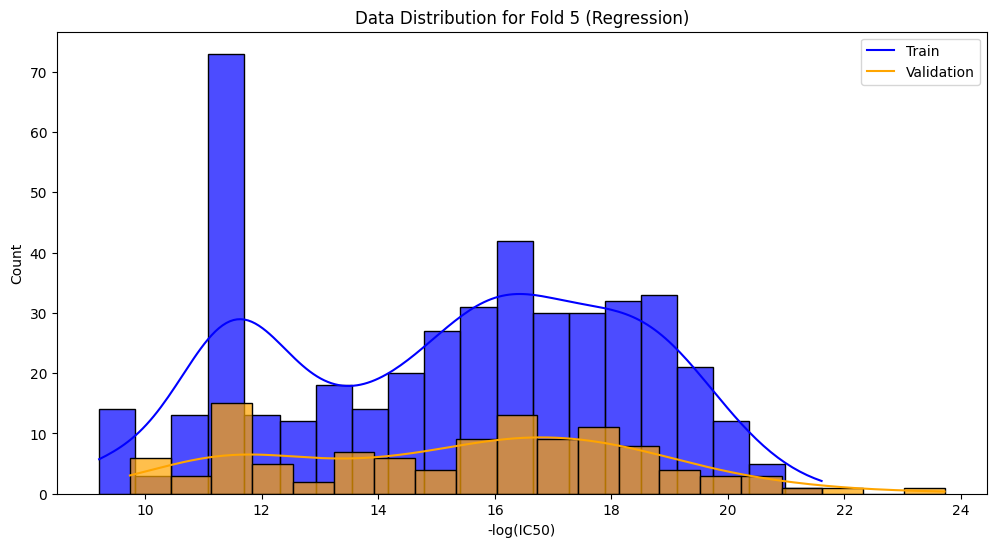

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 5 - Best Model Metric: 5.0521


<Figure size 1000x800 with 0 Axes>

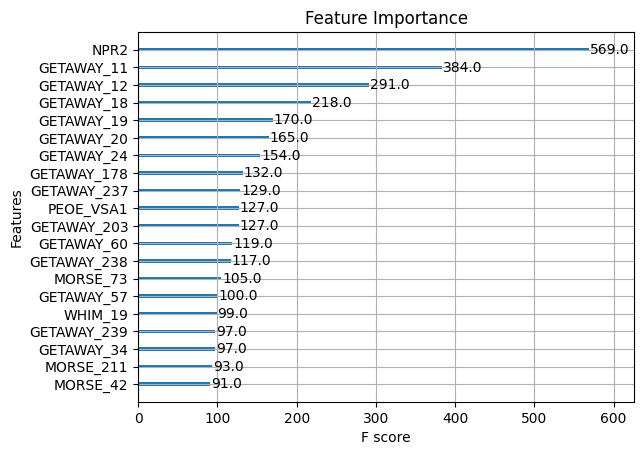

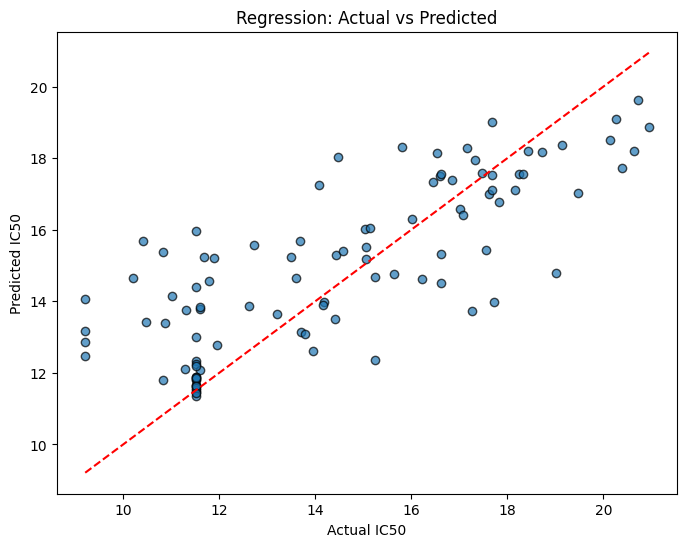

Test Metrics: {'MSE': 4.06495035143073, 'R²': 0.5925102207484644}


In [45]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, r2_score, roc_curve, auc
)
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import gaussian_kde


def get_file_paths(problem_type, input_type_pca, input_type_filter):
    """
    Generate file paths dynamically based on problem type and input type.
    """
    problem = "reg" if problem_type == "regression" else "class"
    base_dir_pca = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_pca}/pre_1_filter/{problem}/"
    base_dir_filter = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_filter}/"
    train_file = os.path.join(base_dir_pca, f"train_pca_reduced_{problem}.csv")
    #test_file = 'PCA_pre_filtered/input/test_reduced_class_Potency.csv'
    test_file = 'PCA_pre_filtered/input/test_reduced_reg_wIC50.csv'
    return train_file, test_file


def load_data(problem_type, train_file, test_file, save_dir=None):
    """
    Load training and test datasets.
    """
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    label_encoder = None

    train_chembl_ids = train_data['Molecule ChEMBL ID']
    test_chembl_ids = test_data['Molecule ChEMBL ID']

    if problem_type == 'regression':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_train = train_data['-logIC50']
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_test = test_data['-logIC50']
    elif problem_type == 'classification':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_train = train_data['Potency'].str.strip()
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_test = test_data['Potency'].str.strip()

        label_encoder = LabelEncoder()
        y_train = pd.Series(label_encoder.fit_transform(y_train), index=y_train.index)
        y_test = pd.Series(label_encoder.transform(y_test), index=y_test.index)

        # Print label mapping for classification
        print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

    # Ensure test data matches training feature columns
    train_features = X_train.columns
    for col in set(train_features) - set(X_test.columns):
        X_test[col] = 0
    X_test = X_test[train_features]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        train_data.to_csv(os.path.join(save_dir, 'modified_train.csv'), index=False)
        test_data.to_csv(os.path.join(save_dir, 'modified_test.csv'), index=False)

    return X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids



def cross_validation(problem_type, model, X_train, y_train, n_splits=5, output_dir=None, label_encoder=None):
    """
    Perform cross-validation with data distribution plots and hyperparameter tuning.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    tuned_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Plot data distribution for the current fold
        plt.figure(figsize=(12, 6))
        if problem_type == "regression":
            sns.histplot(y_train_fold, kde=True, label="Train", color="blue", bins=20, alpha=0.7)
            sns.histplot(y_val_fold, kde=True, label="Validation", color="orange", bins=20, alpha=0.7)
            plt.xlabel("-log(IC50)")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Regression)")
        else:
            sns.countplot(
                x=label_encoder.inverse_transform(y_train_fold),
                label="Train",
                color="blue",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            sns.countplot(
                x=label_encoder.inverse_transform(y_val_fold),
                label="Validation",
                color="orange",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            plt.xlabel("Class")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Classification)")

        plt.legend(["Train", "Validation"])
        if output_dir:
            plt.savefig(os.path.join(output_dir, f"fold_{fold}_data_distribution.png"), dpi=150)
        plt.show()

        # Hyperparameter tuning with RandomizedSearchCV
        param_distributions = {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='neg_mean_squared_error' if problem_type == "regression" else 'accuracy',
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=42,
        )
        random_search.fit(X_train_fold, y_train_fold)

        best_model = random_search.best_estimator_
        tuned_models.append(best_model)

        y_val_pred = best_model.predict(X_val_fold)
        if problem_type == "regression":
            metric = mean_squared_error(y_val_fold, y_val_pred)
        elif problem_type == "classification" and label_encoder is not None:
            metric = accuracy_score(y_val_fold, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    return tuned_models, np.mean(fold_metrics)




def evaluate_model(problem_type, model, X_test, y_test, output_dir, label_encoder=None, test_chembl_ids=None):
    """
    Evaluate the model and save predictions and plots.
    """
    y_pred = model.predict(X_test)
    if problem_type == 'regression':
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(os.path.join(output_dir, "regression_predictions.csv"), index=False)

        # Actual vs Predicted plot
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.xlabel("Actual IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Regression: Actual vs Predicted")
        plt.savefig(os.path.join(output_dir, "regression_actual_vs_predicted.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "regression",
            "input_type": "PCA",
            "MSE": mse,
            "R²": r2
        }])
        performance_summary.to_csv(os.path.join(output_dir, "regression_performance_summary.csv"), index=False)

        return {"MSE": mse, "R²": r2}

    elif problem_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)

        # Convert numeric predictions and true labels back to original class names
        true_classes = label_encoder.inverse_transform(y_test)
        predicted_classes = label_encoder.inverse_transform(y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True Class": true_classes,
            "Predicted Class": predicted_classes
        })
        predictions.to_csv(os.path.join(output_dir, "classification_predictions.csv"), index=False)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix (Test Set)")
        plt.savefig(os.path.join(output_dir, "classification_confusion_matrix.png"))
        plt.show()

        # ROC curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(output_dir, "roc_curve.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "classification",
            "input_type": "PCA",
            "Accuracy": accuracy
        }])
        performance_summary.to_csv(os.path.join(output_dir, "classification_performance_summary.csv"), index=False)

        return {"Accuracy": accuracy}


def main(problem_type, input_type_pca, input_type_filter, output_dir, save_dir=None, model_type="xgboost"):
    """
    Main pipeline for modeling with cross-validation and plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    train_file, test_file = get_file_paths(problem_type, input_type_pca, input_type_filter)
    X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids = load_data(
        problem_type, train_file, test_file, save_dir
    )

    if model_type == "xgboost":
        model = XGBRegressor(random_state=42) if problem_type == 'regression' else XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    elif model_type == "random_forest":
        model = RandomForestRegressor(random_state=42) if problem_type == 'regression' else RandomForestClassifier(random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost' or 'random_forest'.")

    tuned_models, avg_metric = cross_validation(
        problem_type=problem_type,
        model=model,
        X_train=X_train,
        y_train=y_train,
        n_splits=5,
        output_dir=output_dir,
        label_encoder=label_encoder if problem_type == "classification" else None
    )
    best_model = tuned_models[np.argmin(avg_metric)] if problem_type == 'regression' else tuned_models[np.argmax(avg_metric)]

    # Feature importance plot
    if hasattr(best_model, "feature_importances_"):
        plt.figure(figsize=(10, 8))
        plot_importance(best_model, max_num_features=20)
        plt.title("Feature Importance")
        plt.savefig(os.path.join(output_dir, "feature_importance.png"))
        plt.show()

    # Evaluate on test set
    test_metrics = evaluate_model(problem_type, best_model, X_test, y_test, output_dir, label_encoder, test_chembl_ids)
    print(f"Test Metrics: {test_metrics}")


# Example Usage
main(
    problem_type='regression',  # 'classification' or 'regression'
    input_type_pca='PCA',
    input_type_filter='1_filter',
    output_dir=f'PCA_pre_filtered/results/regression/',
    save_dir='PCA_pre_filtered/modified_datasets/',
    model_type="xgboost"  # "xgboost" or "random_forest"
)


## Classification Analysis

Label Mapping: {'High Potency': 0, 'Low Potency': 1, 'Medium Potency': 2}


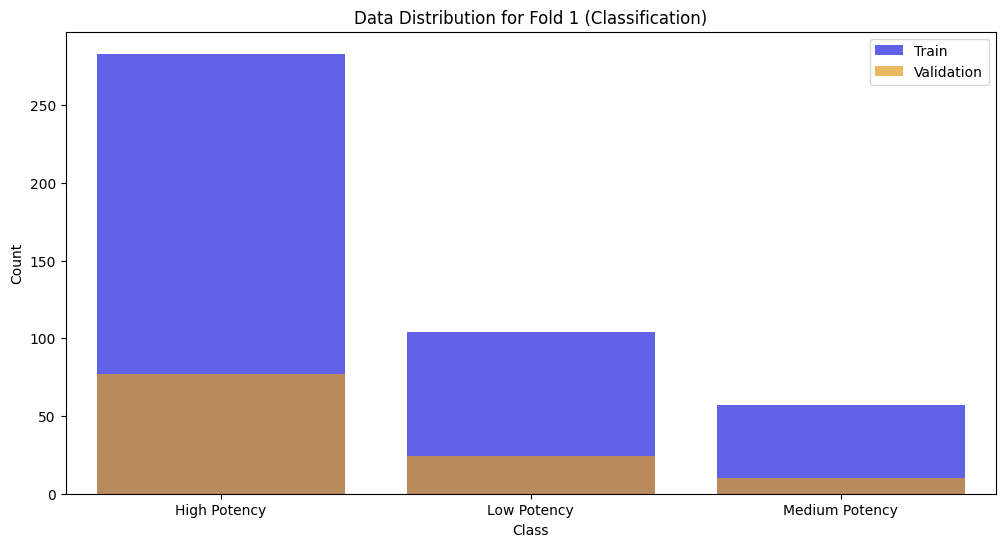

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 1 - Best Model Metric: 0.7477


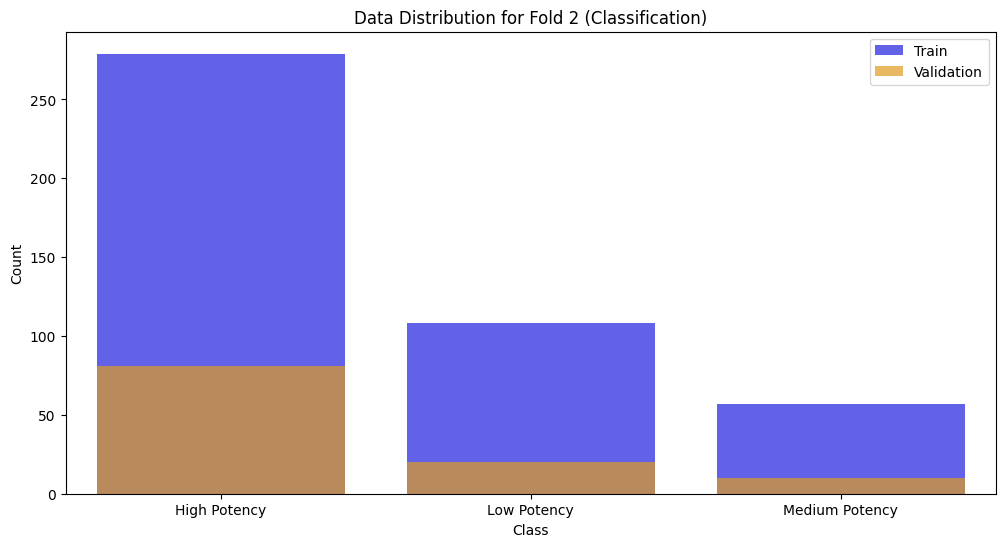

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:36:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 2 - Best Model Metric: 0.8198


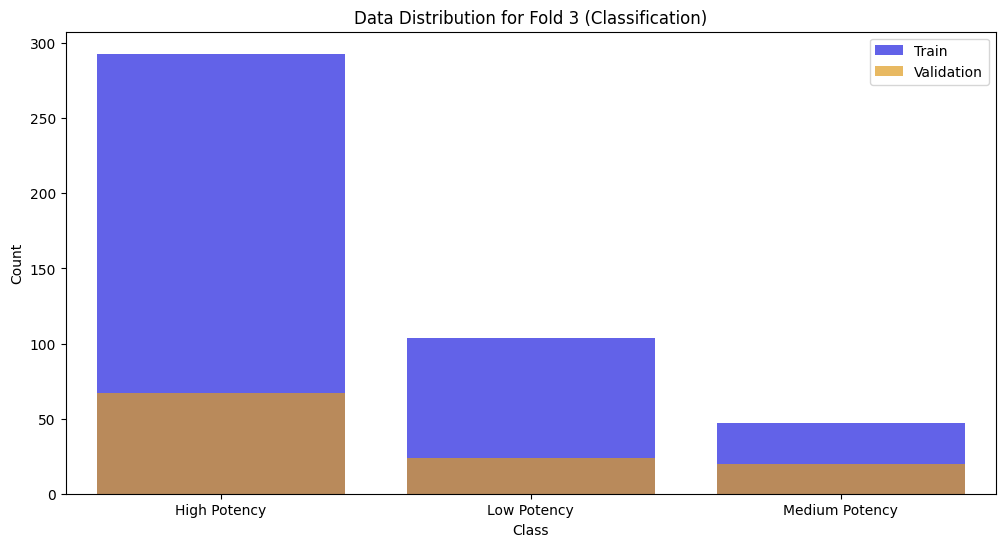

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 3 - Best Model Metric: 0.7387


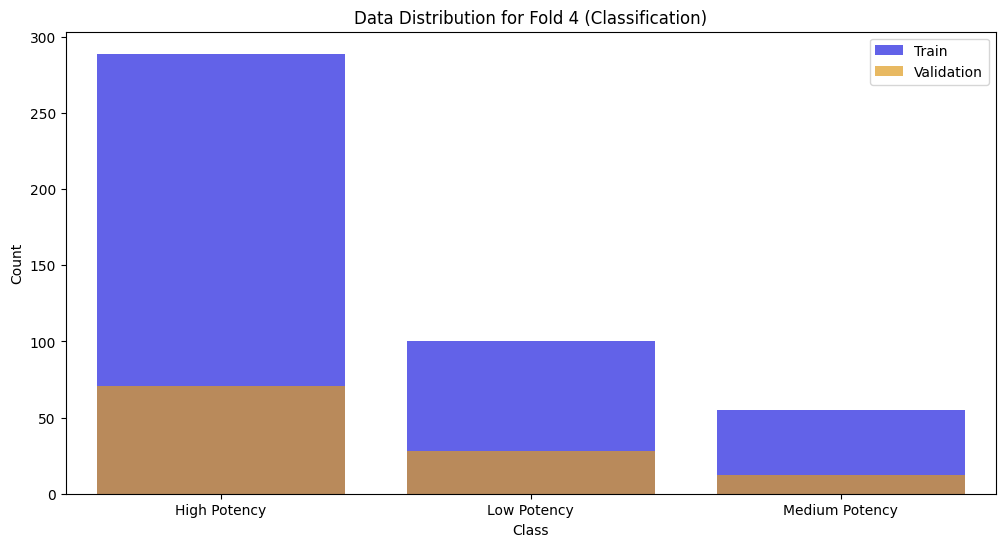

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 4 - Best Model Metric: 0.7658


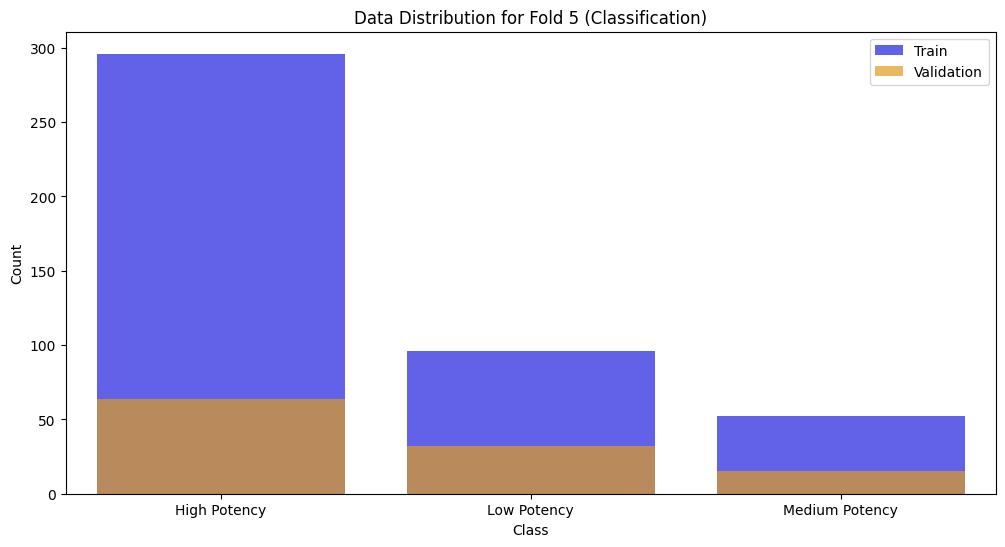

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dolapo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Use

Fold 5 - Best Model Metric: 0.7297


<Figure size 1000x800 with 0 Axes>

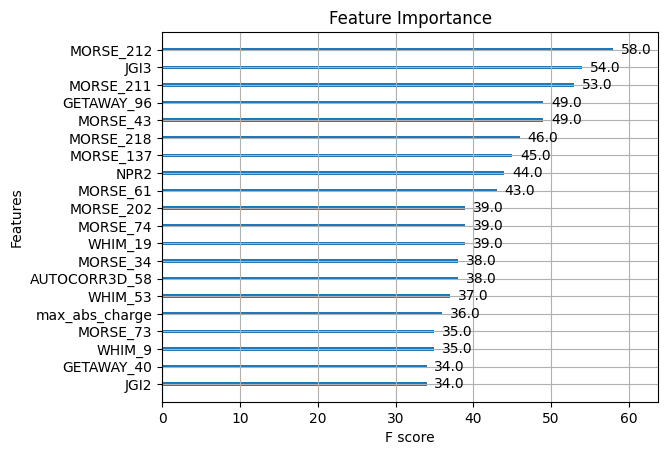

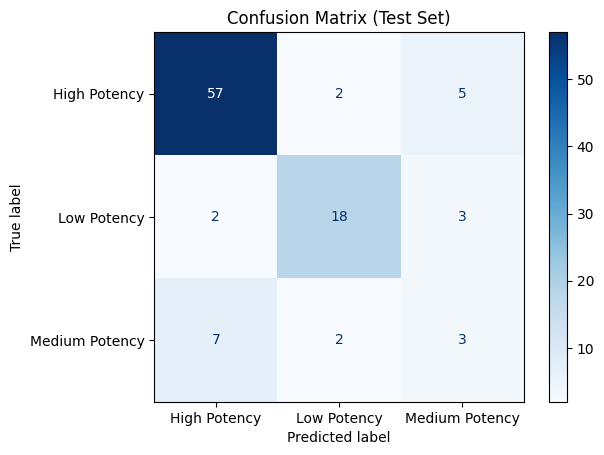

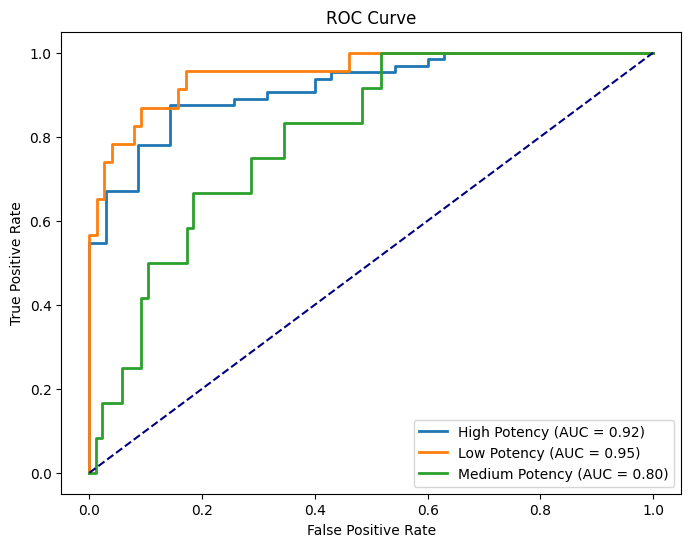

Test Metrics: {'Accuracy': 0.7878787878787878}


In [46]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, r2_score, roc_curve, auc
)
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import gaussian_kde


def get_file_paths(problem_type, input_type_pca, input_type_filter):
    """
    Generate file paths dynamically based on problem type and input type.
    """
    problem = "reg" if problem_type == "regression" else "class"
    base_dir_pca = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_pca}/pre_1_filter/{problem}/"
    base_dir_filter = f"/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/4_feature_selection/{input_type_filter}/"
    train_file = os.path.join(base_dir_pca, f"train_pca_reduced_{problem}.csv")
    test_file = 'PCA_pre_filtered/input/test_reduced_class_Potency.csv'
    #test_file = 'PCA_post_filtered/input/test_reduced_reg_wIC50.csv'
    return train_file, test_file


def load_data(problem_type, train_file, test_file, save_dir=None):
    """
    Load training and test datasets.
    """
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    label_encoder = None

    train_chembl_ids = train_data['Molecule ChEMBL ID']
    test_chembl_ids = test_data['Molecule ChEMBL ID']

    if problem_type == 'regression':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_train = train_data['-logIC50']
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', '-logIC50'])
        y_test = test_data['-logIC50']
    elif problem_type == 'classification':
        X_train = train_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_train = train_data['Potency'].str.split('\n').str[0].str.strip()
        X_test = test_data.drop(columns=['Molecule ChEMBL ID', 'Potency'])
        y_test = test_data['Potency'].str.split('\n').str[0].str.strip()

        label_encoder = LabelEncoder()
        y_train = pd.Series(label_encoder.fit_transform(y_train), index=y_train.index)
        y_test = pd.Series(label_encoder.transform(y_test), index=y_test.index)

        # Print label mapping for classification
        print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

    # Ensure test data matches training feature columns
    train_features = X_train.columns
    for col in set(train_features) - set(X_test.columns):
        X_test[col] = 0
    X_test = X_test[train_features]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        train_data.to_csv(os.path.join(save_dir, 'modified_train.csv'), index=False)
        test_data.to_csv(os.path.join(save_dir, 'modified_test.csv'), index=False)

    return X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids



def cross_validation(problem_type, model, X_train, y_train, n_splits=5, output_dir=None, label_encoder=None):
    """
    Perform cross-validation with data distribution plots and hyperparameter tuning.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    tuned_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Plot data distribution for the current fold
        plt.figure(figsize=(12, 6))
        if problem_type == "regression":
            sns.histplot(y_train_fold, kde=True, label="Train", color="blue", bins=20, alpha=0.7)
            sns.histplot(y_val_fold, kde=True, label="Validation", color="orange", bins=20, alpha=0.7)
            plt.xlabel("-log(IC50)")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Regression)")
        else:
            sns.countplot(
                x=label_encoder.inverse_transform(y_train_fold),
                label="Train",
                color="blue",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            sns.countplot(
                x=label_encoder.inverse_transform(y_val_fold),
                label="Validation",
                color="orange",
                alpha=0.7,
                order=sorted(label_encoder.classes_)
            )
            plt.xlabel("Class")
            plt.ylabel("Count")
            plt.title(f"Data Distribution for Fold {fold} (Classification)")

        plt.legend(["Train", "Validation"])
        if output_dir:
            plt.savefig(os.path.join(output_dir, f"fold_{fold}_data_distribution.png"), dpi=150)
        plt.show()

        # Hyperparameter tuning with RandomizedSearchCV
        param_distributions = {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='neg_mean_squared_error' if problem_type == "regression" else 'accuracy',
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=42,
        )
        random_search.fit(X_train_fold, y_train_fold)

        best_model = random_search.best_estimator_
        tuned_models.append(best_model)

        y_val_pred = best_model.predict(X_val_fold)
        if problem_type == "regression":
            metric = mean_squared_error(y_val_fold, y_val_pred)
        elif problem_type == "classification" and label_encoder is not None:
            metric = accuracy_score(y_val_fold, y_val_pred)

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    return tuned_models, np.mean(fold_metrics)




def evaluate_model(problem_type, model, X_test, y_test, output_dir, label_encoder=None, test_chembl_ids=None):
    """
    Evaluate the model and save predictions and plots.
    """
    y_pred = model.predict(X_test)
    if problem_type == 'regression':
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(os.path.join(output_dir, "regression_predictions.csv"), index=False)

        # Actual vs Predicted plot
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
        plt.xlabel("Actual IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Regression: Actual vs Predicted")
        plt.savefig(os.path.join(output_dir, "regression_actual_vs_predicted.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "regression",
            "input_type": "PCA",
            "MSE": mse,
            "R²": r2
        }])
        performance_summary.to_csv(os.path.join(output_dir, "regression_performance_summary.csv"), index=False)

        return {"MSE": mse, "R²": r2}

    elif problem_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)

        # Convert numeric predictions and true labels back to original class names
        true_classes = label_encoder.inverse_transform(y_test)
        predicted_classes = label_encoder.inverse_transform(y_pred)

        # Save predictions
        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": test_chembl_ids,
            "True Class": true_classes,
            "Predicted Class": predicted_classes
        })
        predictions.to_csv(os.path.join(output_dir, "classification_predictions.csv"), index=False)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix (Test Set)")
        plt.savefig(os.path.join(output_dir, "classification_confusion_matrix.png"))
        plt.show()

        # ROC curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(output_dir, "roc_curve.png"))
        plt.show()

        # Save performance summary
        performance_summary = pd.DataFrame([{
            "model_type": "XGBoost",
            "problem_type": "classification",
            "input_type": "PCA",
            "Accuracy": accuracy
        }])
        performance_summary.to_csv(os.path.join(output_dir, "classification_performance_summary.csv"), index=False)

        return {"Accuracy": accuracy}


def main(problem_type, input_type_pca, input_type_filter, output_dir, save_dir=None, model_type="xgboost"):
    """
    Main pipeline for modeling with cross-validation and plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    train_file, test_file = get_file_paths(problem_type, input_type_pca, input_type_filter)
    X_train, y_train, X_test, y_test, label_encoder, test_chembl_ids = load_data(
        problem_type, train_file, test_file, save_dir
    )

    if model_type == "xgboost":
        model = XGBRegressor(random_state=42) if problem_type == 'regression' else XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    elif model_type == "random_forest":
        model = RandomForestRegressor(random_state=42) if problem_type == 'regression' else RandomForestClassifier(random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost' or 'random_forest'.")

    tuned_models, avg_metric = cross_validation(
        problem_type=problem_type,
        model=model,
        X_train=X_train,
        y_train=y_train,
        n_splits=5,
        output_dir=output_dir,
        label_encoder=label_encoder if problem_type == "classification" else None
    )
    best_model = tuned_models[np.argmin(avg_metric)] if problem_type == 'regression' else tuned_models[np.argmax(avg_metric)]

    # Feature importance plot
    if hasattr(best_model, "feature_importances_"):
        plt.figure(figsize=(10, 8))
        plot_importance(best_model, max_num_features=20)
        plt.title("Feature Importance")
        plt.savefig(os.path.join(output_dir, "feature_importance.png"))
        plt.show()

    # Evaluate on test set
    test_metrics = evaluate_model(problem_type, best_model, X_test, y_test, output_dir, label_encoder, test_chembl_ids)
    print(f"Test Metrics: {test_metrics}")


# Example Usage
main(
    problem_type='classification',  # 'classification' or 'regression'
    input_type_pca='PCA',
    input_type_filter='1_filter',
    output_dir=f'PCA_pre_filtered/results/classification/',
    save_dir='PCA_pre_filtered/modified_datasets/',
    model_type="xgboost"  # "xgboost" or "random_forest"
)
